# Text Classification

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express about
your company’s product on Twitter. In this chapter, we’ll tackle this task using a variant
of BERT called DistilBERT. The main advantage of this model is that it achieves
comparable performance to BERT, while being significantly smaller and more efficient.
This enables us to train a classifier in a few minutes.

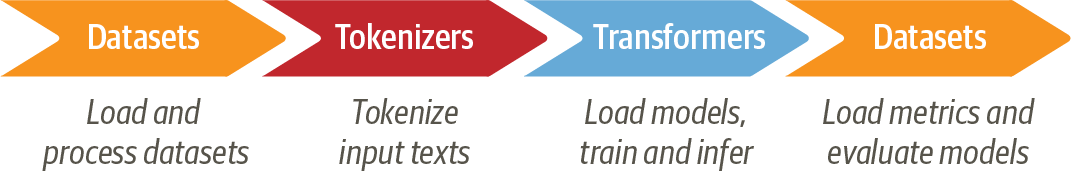

Figure 2-2. A typical pipeline for training transformer models with the Hugging Face Datasets, Tokenizers, and Transformers libraries

## Dataset

dataset contains
six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet,
our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

In [48]:
import datasets
print(datasets.__version__)

3.5.0


In [49]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


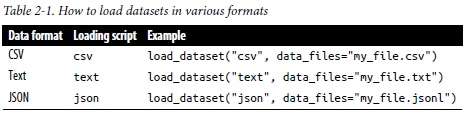

#### load url

```
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

# peek at first row of train.txt
!head -n 1 train.txt

# load the file
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                                names=["text", "label"])

# or mention URL itself
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                                names=["text", "labels"])
```

### From Datasets to DataFrames

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


labels are represented as integers, use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Look at the Class Distribution

Matplotlib is building the font cache; this may take a moment.


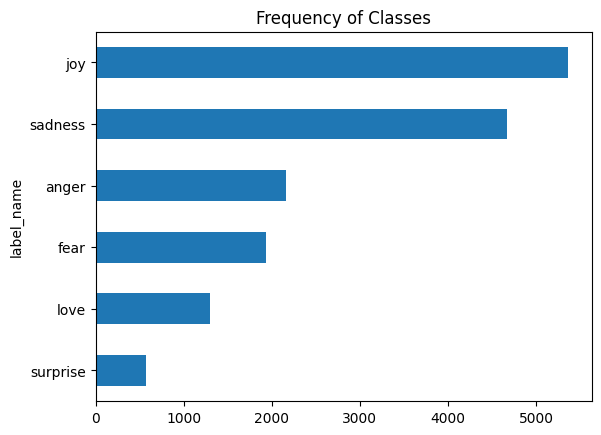

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness
classes appear frequently, whereas love and surprise are about 5–10 times rarer.
There are several ways to deal with imbalanced data, including:

- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.

- Imbalanced-learn library

### How Long are your Tweets?

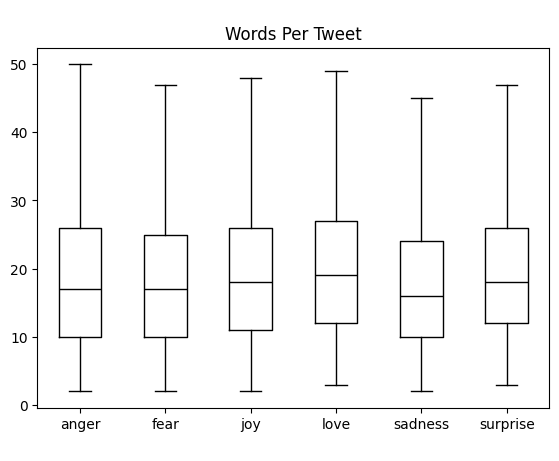

In [ ]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
            showfliers=False, color="black")
plt.suptitle(" ")
plt.xlabel(" ")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long
and the longest tweets are well below DistilBERT’s maximum context size. Texts that
are longer than a model’s context size need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information; in this case, it looks
like that won’t be an issue.

Let’s now figure out how we can convert these raw texts into a format suitable for
Transformers! While we’re at it, let’s also reset the output format of our dataset
since we don’t need the DataFrame format anymore:

In [ ]:
emotions.reset_format()

## From Text to Tokens

### Character Tokenization

In [ ]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


We can now use token2idx to transform the tokenized text to a list of integers:

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


last step is to convert input_ids to a 2D tensor of one-hot vectors

In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


We won't be using this, Not good for neural networks. In pandas, one-hot encoding can be implemented with get_dummies() function as follows:

In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


We can create the one-hot encodings in PyTorch by converting input_ids to a tensor and applying the one_hot() function as follows:

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

C:\Users\Pulkit Vyas\AppData\Local\Temp\ipykernel_10276\4005198375.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


torch.Size([37, 19])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions,
since our vocabulary consists of 20 unique characters.

WARN: It’s important to always set num_classes in the one_hot() function
because otherwise the one-hot vectors may end up being shorter
than the length of the vocabulary (and need to be padded with
zeros manually). In TensorFlow, the equivalent function is
tf.one_hot(), where the depth argument plays the role of
num_classes.

In [ ]:
# first vector
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any
structure in the text and treats the whole string as a stream of characters. Although
this helps deal with misspellings and rare words, the main drawback is that linguistic
structures such as words need to be learned from the data. This requires significant
compute, memory, and data. For this reason, character tokenization is rarely used in
practice. Instead, some structure of the text is preserved during the tokenization step.
Word tokenization is a straightforward approach to achieve this, so let’s take a look at
how it works.

### Word Tokenization

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


NOTE: Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem (e.g. "great", "greater", "greatest" all become "great"), at the expense of losing some information in the text.

Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character
and word tokenization. On the one hand, we want to split rare words into smaller
units to allow the model to deal with complex words and misspellings. On the other
hand, we want to keep frequent words as unique entities so that we can keep the
length of our inputs to a manageable size. The main distinguishing feature of
subword tokenization (as well as word tokenization) is that it is learned from the pretraining
corpus using a mix of statistical rules and algorithms.

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically
retrieve the model’s configuration, pretrained weights, or vocabulary from
the name of the checkpoint. This allows you to quickly switch between models, but if
you wish to load the specific class manually you can do so as well. For example, we
could have loaded the DistilBERT tokenizer as follows:

In [ ]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

lets see how tokenizer works:

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can see that the words have been mapped to unique integers in the input_ids field. attention_mask will be discussed later. Now that we have the input_ids field, we can convert them back into tokens using tokenizer's convert_ids_to_tokens() method:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


We can observe three things here. First, some special [CLS] and [SEP] tokens have
been added to the start and end of the sequence. These tokens differ from model to
model, but their main role is to indicate the start and end of a sequence. Second, the
tokens have each been lowercased, which is a feature of this particular checkpoint.
Finally, we can see that “tokenizing” and “NLP” have been split into two tokens,
which makes sense since they are not common words. The ## prefix in ##izing and
##p means that the preceding string is not whitespace; any token with this prefix
should be merged with the previous token when you convert the tokens back to a
string. 

The AutoTokenizer class has a convert_tokens_to_string() method for
doing just that, so let’s apply it to our tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


AutoTokenizer has several attributes, we can inspect the vocabulary size:

In [ ]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [ ]:
tokenizer.model_max_length

512

another attribute - name of the fields that the model expects in its forward_pass

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

WARN: When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat", you'd have a hard time understanding what was going on too!

## Tokenizing The Whole Dataset

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. 

In [ ]:
# tokenize in action - batch of 2 examples
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

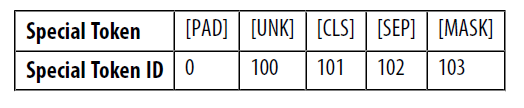

Also note that in addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. Figure 2-3 provides a visual explanation of how the input IDs and attention masks are padded.

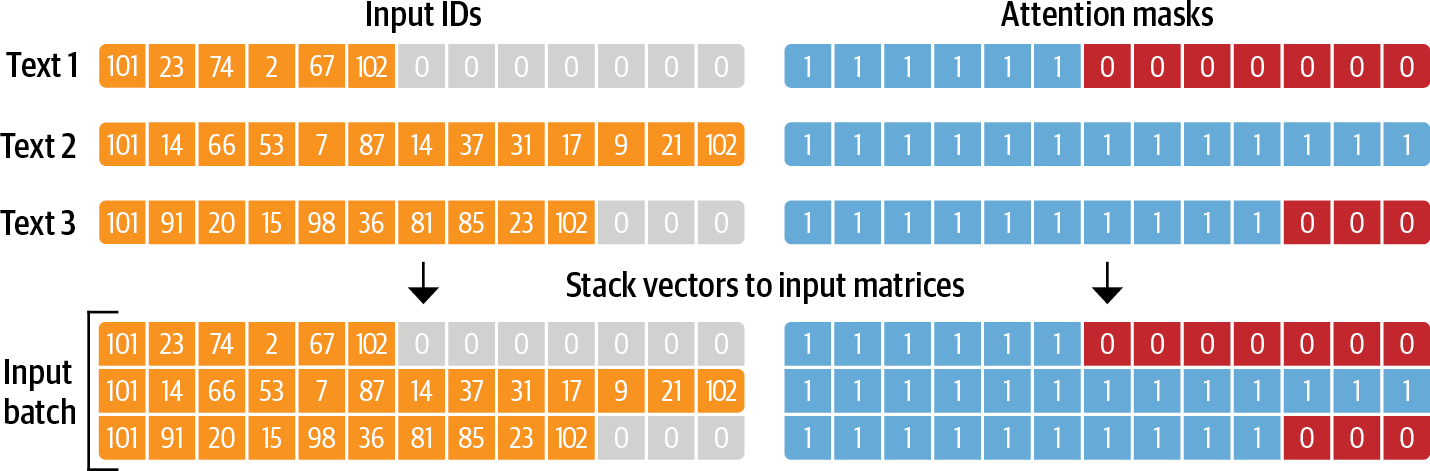

Figure 2-3. For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors.

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 13269.61 examples/s]


By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we've set batch_size=True, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see this operation has added new input_ids and attention_mask columns to the dataset:

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


NOTE: In later chapters, we'll see how data collators can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## Training a Text Classifier

models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in Figure 2-4.

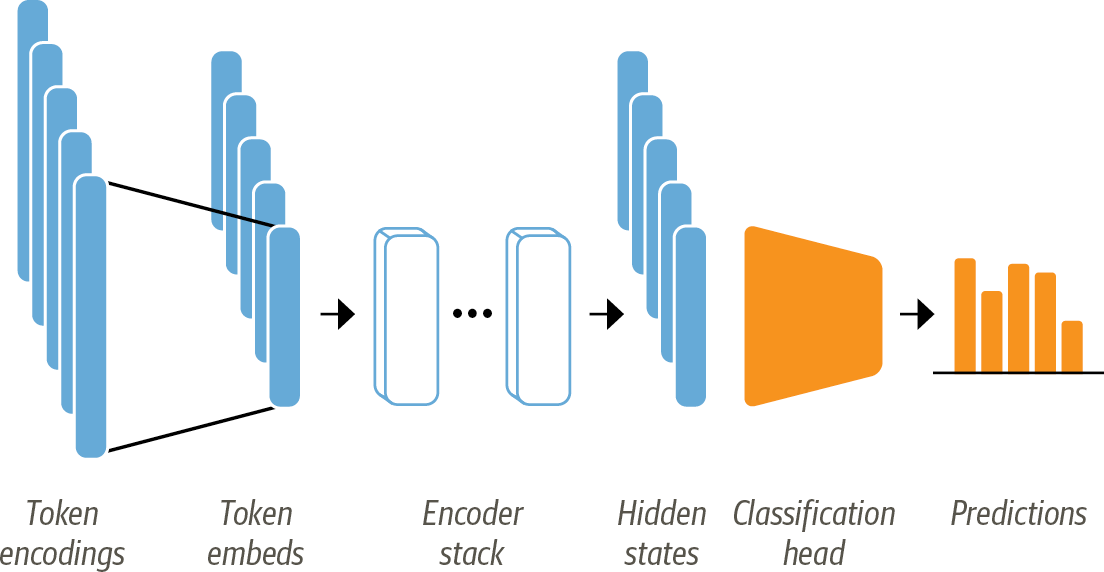

Figure 2-4. The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body with a custom classification head

First the text is tokenized and represented as one-hot vectors called token encodings. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k-200k unique tokens. Next, these token encodings are converted to token embeddings, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token. For the pretraining objective of language modeling, each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

NOTE: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in Chapter 3 when we use the nn.Embedding class.

We have two options to train such a model on our Twitter dataset:

- Feature Extraction: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- Fine-Tuning: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

## Transformers as Feature Extractors

Using a transformer as a feature extractor is fairly simple. As shown in Figure 2-5, we freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

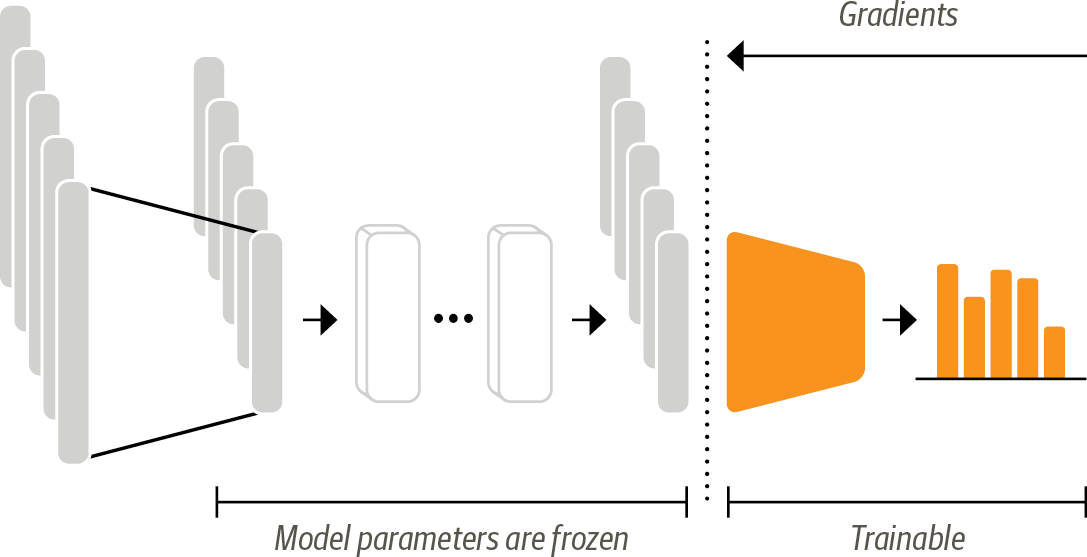

Figure 2-5. In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier

### Using pretrained models

We will use another convenient auto class from Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch nn.Module.to() method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

### Extracting the last hidden states

To warm up, let's retrieve the last hidden states for a single string. The first thing we need to do is to encode the string and convert the tokens to PyTorch tensors. This can be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we've used the torch.no_grad() context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a namedtuple in Python. In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string; let's do the same for the whole dataset by creating a new hidden_state column that stores all these vectors. As we did with tokenizer, we'll use the map() method of DatasetDict to extract all the hidden states in one go. The first thing we need to do is to wrap the previous steps in a processing function:

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

The only difference between this function and our previous logic is the final step where we place the final hidden state back on the CPU as a NumPy array. The map() method requires the processing function to return Python or NumPy objects when we're using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

In [47]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

ValueError: PyTorch needs to be installed to be able to return PyTorch tensors.

We can go ahead and extract the hidden states across